# Data Separation

Author: Gillian A. McGinnis, final-semester M.S. Information Science - Machine Learning  
The University of Arizona College of Information  
INFO 698 - Capstone  
Start date: 21 October 2025  
Last updated: 21 October 2025

In [1]:
"""
Module providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.
"""

'\nModule providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.\n'

## Setup

### Packages

In [2]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# # import matplotlib.ticker as ticker
# import matplotlib.dates as mdates
# import datetime as dt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [3]:
## (Optional chunk)
# Current session information
import session_info
session_info.show(dependencies=False)

### Data

In [4]:
united_water = pd.read_parquet('data/clean/water.parquet')
united_soil = pd.read_parquet('data/clean/soil.parquet')

## Prepare

In [ ]:
u_w_mini = united_water.copy()[['weir_level_cal', 'ra_rain']]['2015-01-01 00:00:00':'2015-02-01 00:00:00']
# print(u_w_mini.info())

is_cal = u_w_mini['weir_level_cal'].notna()
g_id = is_cal.cumsum()
# g_id
u_w_mini['since_cal'] = u_w_mini.groupby(g_id).cumcount()
del is_cal, g_id

u_w_mini

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8940 entries, 2015-01-01 00:00:00 to 2015-02-01 00:00:00
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   weir_level_cal  17 non-null     float64
 1   ra_rain         58 non-null     float64
dtypes: float64(2)
memory usage: 209.5 KB
None


,weir_level_cal,ra_rain,since_cal
datetime,,,
2015-01-01 00:00:00,NaN,NaN,0
2015-01-01 00:05:00,NaN,NaN,1
2015-01-01 00:10:00,NaN,NaN,2
2015-01-01 00:15:00,NaN,NaN,3
2015-01-01 00:20:00,NaN,NaN,4
...,...,...,...
2015-01-31 23:40:00,NaN,NaN,469
2015-01-31 23:45:00,NaN,NaN,470
2015-01-31 23:50:00,NaN,NaN,471


In [5]:
# water_m = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]['2010-12-28 10:00:00':'2011-01-05 23:59:59']
water_m = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]

null_mask = water_m['ra_rain'].isnull()
g_id_event = null_mask.cumsum()
water_m['r_event_sum'] = water_m.groupby(g_id_event)['ra_rain'].cumsum()

is_rain = water_m['ra_rain'].notna()
g_id = is_rain.cumsum()
# g_id
water_m['since_rain'] = water_m.groupby(g_id).cumcount()
water_m['dec'] = np.exp(-0.1*water_m['since_rain'])
water_m['rain_fill'] = water_m['r_event_sum'].ffill()
# data_u['1_shallow_f'] = data_u['1_shallow'].ffill()
water_m['rain_dec'] = (water_m['rain_fill']*water_m['dec'])

# water_m.drop(columns=['level_ro'])
# water_m = water_mini['2010-12-28 10:00:00':'2011-01-05 23:59:59']
# water_m['1992-04-23 18:00:00':'1992-04-23 23:59:59']

/var/folders/dr/4_7b2hbn60q7cynx4gmn5vhr0000gp/T/ipykernel_95011/2791175752.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_m['r_event_sum'] = water_m.groupby(g_id_event)['ra_rain'].cumsum()
/var/folders/dr/4_7b2hbn60q7cynx4gmn5vhr0000gp/T/ipykernel_95011/2791175752.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_m['since_rain'] = water_m.groupby(g_id).cumcount()
/var/folders/dr/4_7b2hbn60q7cynx4gmn5vhr0000gp/T/ipykernel_95011/2791175752.py:12: SettingWithCopyWarning: 
A value is trying

In [6]:
water_mini = pd.merge(
    united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']],
    water_m[['rain_dec', 'since_rain']],
    left_index=True,
    right_index=True,
    # soil_mini_shallow.reset_index(),
    # soil_mini_deep.reset_index(),
    # on = ["date", "sample"],
    # suffixes = ("_shallow", "_deep"),
    how = "outer"
    )
# g_id
# is_rain_event = (water_mini['since_rain'] == 0)
# g_id_rain = is_rain_event.cumsum()
# water_mini.groupby(g_id_rain).cumcount()

del water_m, null_mask, g_id_event, is_rain, g_id

In [7]:
## Subset for testing
# water_mini = united_water['2010-01-01 00:00:00':'2012-12-31 23:59:59']
# water_mini = united_water.copy()
# water_mini
# water_mini = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]

water_mini['ra_rain'] = water_mini['ra_rain'].fillna(0)
water_mini = water_mini.dropna()
water_mini.head()

,raw_ro,level_ro,ra_rain,obstruction_ro,rain_dec,since_rain
datetime,,,,,,
1989-07-19 11:55:00,12.4,12.4,0.0,False,112.378998,1
1989-07-19 12:00:00,12.4,12.4,0.0,False,101.684722,2
1989-07-19 12:05:00,12.4,12.4,0.0,False,92.008141,3
1989-07-19 12:10:00,12.5,12.5,0.0,False,83.252409,4
1989-07-19 12:15:00,12.2,12.2,0.0,False,75.329895,5


Calculate distance from previous rainfall

In [8]:
# w_m = water_mini['1989-07-19 11:55:00':'1991-07-19 11:55:00'].copy()

In [9]:
# # is_rain = (w_m['ra_rain'] != 0)
# # g_id = is_rain.cumsum()
# # w_m['since_rain'] = w_m.groupby(g_id).cumcount()
# # w_m

# is_rain = (water_mini['ra_rain'] != 0)
# g_id = is_rain.cumsum()
# water_mini['since_rain'] = water_mini.groupby(g_id).cumcount()
# water_mini.head()

# # del is_rain, g_id

In [10]:
# # g_id
# is_rain_event = (water_mini['since_rain'] == 0)
# g_id_rain = is_rain_event.cumsum()
# water_mini.groupby(g_id_rain).cumcount()

Calculate the difference from previous value

In [11]:
water_mini['diff_ro'] = water_mini['raw_ro'].diff()
# fix first NA
water_mini['diff_ro'] = water_mini['diff_ro'].fillna(0)
water_mini[['raw_ro', 'diff_ro']].head()

,raw_ro,diff_ro
datetime,,
1989-07-19 11:55:00,12.4,0.0
1989-07-19 12:00:00,12.4,0.0
1989-07-19 12:05:00,12.4,0.0
1989-07-19 12:10:00,12.5,0.1
1989-07-19 12:15:00,12.2,-0.3


In [12]:
water_mini['1992-04-23 18:00:00':'1992-04-23 18:30:00']

,raw_ro,level_ro,ra_rain,obstruction_ro,rain_dec,since_rain,diff_ro
datetime,,,,,,,
1992-04-23 18:00:00,0.0,0.0,0.000,False,8.637553e-165,3764,0.0
1992-04-23 18:05:00,0.0,0.0,0.000,False,7.815581e-165,3765,0.0
1992-04-23 18:10:00,0.0,0.0,0.000,False,4.596574e-01,1,0.0
1992-04-23 18:15:00,0.0,0.0,0.000,False,2.298287e-01,1,0.0
1992-04-23 18:20:00,0.0,0.0,0.508,False,1.016000e+00,0,0.0
1992-04-23 18:25:00,0.0,0.0,0.000,False,1.608801e+00,1,0.0
1992-04-23 18:30:00,0.0,0.0,0.000,False,2.298287e-01,1,0.0


In [13]:
# # soil_mini = united_soil[['sample', 'h2o_by_wet_shallow', 'h2o_by_wet_deep']]
# soil_mini = united_soil.copy()
# # soil_mini = soil_mini.reset_index()
# # # soil_mini['sample'] = soil_mini['sample'].astype('category')
# # # soil_mini['dup'] = soil_mini.duplicated()
# # print(len(soil_mini[soil_mini.duplicated()==False]))
# # print(len(soil_mini.drop_duplicates()))
# # # united_soil[united_soil['chk_note_shallow']=='doubtful']
# # # soil_mini['sample'] = soil_mini['sample'].astype('category')
# # # soil_mini = soil_mini[['sample', 'h2o_by_wet_shallow', 'h2o_by_wet_deep']]
# # # soil_mini

In [14]:
# water_mini = water_mini[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]
# water_mini

In [15]:
# len(soil_mini)

In [16]:
soil_mini_shallow = united_soil.copy().drop('h2o_by_wet_deep', axis=1)
soil_mini_shallow = soil_mini_shallow.pivot(columns='sample', values='h2o_by_wet_shallow')

soil_mini_deep = united_soil.copy().drop('h2o_by_wet_shallow', axis=1)
soil_mini_deep = soil_mini_deep.pivot(columns='sample', values='h2o_by_wet_deep')

soil_mini = pd.merge(
    soil_mini_shallow,
    soil_mini_deep,
    left_index=True,
    right_index=True,
    # soil_mini_shallow.reset_index(),
    # soil_mini_deep.reset_index(),
    # on = ["date", "sample"],
    suffixes = ("_shallow", "_deep"),
    how = "outer"
    )

soil_mini.head()

sample,1_shallow,2_shallow,3_shallow,4_shallow,5_shallow,6_shallow,7_shallow,8_shallow,9_shallow,10_shallow,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
date,,,,,,,,,,,,,,,,,,,,
1989-06-23,35.4,40.4,35.3,37.1,41.0,35.2,44.5,44.6,33.2,32.3,36.1,37.1,35.5,35.1,39.1,32.2,35.3,30.2,32.0,29.9
1989-06-30,35.7,43.5,36.7,37.2,44.1,35.3,37.4,41.7,32.3,33.5,36.7,39.8,36.2,31.0,38.6,30.7,32.5,29.3,30.4,29.5
1989-07-06,36.5,44.1,37.1,37.7,43.8,35.5,44.5,44.0,33.3,31.7,35.8,39.6,31.1,34.5,39.8,34.5,34.9,32.2,32.2,29.6
1989-07-13,36.9,40.3,40.6,35.7,41.9,39.8,38.6,33.9,31.3,32.3,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-20,35.1,40.4,37.0,38.8,43.6,37.4,36.1,31.3,29.8,32.5,35.4,37.1,35.5,35.1,38.1,29.5,33.8,27.0,30.6,30.4


### Unite

In [17]:
# water_mini_test = water_mini['1990-01-01 00:00:00':'1992-12-31 23:23:59']
# print(len(water_mini_test))
# soil_mini_test = soil_mini['1990-01-01 00:00:00':'1992-12-31 23:23:59']

In [18]:
data_united = pd.merge(
    water_mini,
    soil_mini,
    left_index=True,
    right_index=True,
    # soil_mini_shallow.reset_index(),
    # soil_mini_deep.reset_index(),
    # on = ["date", "sample"],
    # suffixes = ("_shallow", "_deep"),
    how = "outer"
    )

# mini_mini_test = mini_test['1992-04-09 00:00:00':'1992-04-09 23:23:59']
# mini_mini_test
# mini_test['soil_stale'] = 
data_united.head()

,raw_ro,level_ro,ra_rain,obstruction_ro,rain_dec,since_rain,diff_ro,1_shallow,2_shallow,3_shallow,...,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
1989-06-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.4,40.4,35.3,...,36.1,37.1,35.5,35.1,39.1,32.2,35.3,30.2,32.0,29.9
1989-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.7,43.5,36.7,...,36.7,39.8,36.2,31.0,38.6,30.7,32.5,29.3,30.4,29.5
1989-07-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.5,44.1,37.1,...,35.8,39.6,31.1,34.5,39.8,34.5,34.9,32.2,32.2,29.6
1989-07-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.9,40.3,40.6,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 11:55:00,12.4,12.4,0.0,False,112.378998,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_u = data_united['1989-07-19 11:55:00':'1989-08-15 00:00:00']

In [ ]:
# data_u = data_united['1989-07-19 11:55:00':'1989-08-15 00:00:00']
data_u = data_u[['raw_ro', '1_shallow', '2_shallow']]
# cols_to_check = [col for col in data_u.columns if (col.endswith('shallow') | col.endswith('deep'))]
# is_soil = data_u[cols_to_check].notna()
# g_id = is_soil.cumsum()
# g_id

col_to_check = "1_shallow"
is_soil = data_u[col_to_check].notna()
g_id = is_soil.cumsum()
# g_id
data_u['since_soil'] = data_u.groupby(g_id).cumcount()
data_u['dec'] = np.exp(-0.001*data_u['since_soil'])
data_u['1_shallow_f'] = data_u['1_shallow'].ffill()
data_u['1_shallow_w'] = (data_u['1_shallow_f']*data_u['dec'])
data_u

# finding most freq
# g_id['most'] = g_id.mode(axis=1)[0]
# data_u['since_soil'] = data_u.groupby(g_id).cumcount()
# data_u

# g_id = is_rain.cumsum()
# water_mini['since_rain'] = water_mini.groupby(g_id).cumcount()
# water_mini.head()
del col_to_check, is_soil, g_id, data_u

In [19]:
cols_to_fill = [col for col in data_united.columns if (col.endswith('shallow') | col.endswith('deep'))]
data_united[cols_to_fill] = data_united[cols_to_fill].ffill()
## Only fill for the exact day the measurement was taken
# data_united[cols_to_fill] = data_united[cols_to_fill].groupby(pd.Grouper(freq='D')).ffill()
data_united = data_united.dropna(subset='obstruction_ro')
data_united.head()

,raw_ro,level_ro,ra_rain,obstruction_ro,rain_dec,since_rain,diff_ro,1_shallow,2_shallow,3_shallow,...,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
1989-07-19 11:55:00,12.4,12.4,0.0,False,112.378998,1.0,0.0,36.9,40.3,40.6,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:00:00,12.4,12.4,0.0,False,101.684722,2.0,0.0,36.9,40.3,40.6,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:05:00,12.4,12.4,0.0,False,92.008141,3.0,0.0,36.9,40.3,40.6,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:10:00,12.5,12.5,0.0,False,83.252409,4.0,0.1,36.9,40.3,40.6,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:15:00,12.2,12.2,0.0,False,75.329895,5.0,-0.3,36.9,40.3,40.6,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8


In [ ]:
# # data_united['1989-07-19 11:55:00':'1989-07-30 11:55:00']
# # data_united[data_united['obstruction_ro']==True]
# data_u = data_united['2010-12-28 10:00:00':'2011-01-05 23:59:59']
# data_u['rain_event']
# # data_united[data_united['since_rain']==0]

### Train/Test (80/20)

In [20]:
# # mini_xy = water_mini[['level_ro', 'raw_ro', 'chk_note_ro', 'source_ro']].dropna()
# mini_xy = water_mini.copy().drop('level_ro', axis=1).dropna()
# mini_y = mini_xy['obstruction_ro']
# # mini_x = mini_xy[['raw_ro', 'chk_note_ro', 'source_ro']]
# mini_x = mini_xy.drop('obstruction_ro', axis=1)
# mini_xy

united_y = data_united['obstruction_ro']
united_x = data_united.drop(['obstruction_ro', 'level_ro'], axis=1)

In [21]:
print("Test:\t20p of", len(united_y), "is", round(.2*len(united_y)))
print("Train:\t80p of", len(united_y), "is", round(.8*len(united_y)))
print(round(.2*len(united_y)) + round(.8*len(united_y)))

# mini_x.index[1]

Test:	20p of 3557026 is 711405
Train:	80p of 3557026 is 2845621
3557026


In [22]:
x_train, x_test, y_train, y_test = train_test_split(united_x, united_y, test_size = 0.2, shuffle=False)

print(
    "Train:\t", len(x_train), "\t", x_train.index[0], "thru", x_train.index[-1],
    "\nTest:\t", len(x_test), "\t\t", x_test.index[0], "thru", x_test.index[-1]
    # len(x_train), len(x_test), "\n",
    # x_train.index[-1]
)

Train:	 2845620 	 1989-07-19 11:55:00 thru 2018-10-27 09:10:00 
Test:	 711406 		 2018-10-27 09:15:00 thru 2025-08-01 13:00:00


### Sliding Window

In [23]:
tscv = TimeSeriesSplit(n_splits=29)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=29, test_size=None)


In [24]:
# print(tscv)
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    # print("  Train: index=", mini_x.index[train_index])
    # print(f"  Test:  index={val_index}")
    print("--------------------------------------------------")

del i, train_index, val_index

Fold 0:
  Train: index=[    0     1     2 ... 94851 94852 94853]
  Test:  index=[ 94854  94855  94856 ... 189705 189706 189707]
--------------------------------------------------
Fold 1:
  Train: index=[     0      1      2 ... 189705 189706 189707]
  Test:  index=[189708 189709 189710 ... 284559 284560 284561]
--------------------------------------------------
Fold 2:
  Train: index=[     0      1      2 ... 284559 284560 284561]
  Test:  index=[284562 284563 284564 ... 379413 379414 379415]
--------------------------------------------------
Fold 3:
  Train: index=[     0      1      2 ... 379413 379414 379415]
  Test:  index=[379416 379417 379418 ... 474267 474268 474269]
--------------------------------------------------
Fold 4:
  Train: index=[     0      1      2 ... 474267 474268 474269]
  Test:  index=[474270 474271 474272 ... 569121 569122 569123]
--------------------------------------------------
Fold 5:
  Train: index=[     0      1      2 ... 569121 569122 569123]
  Test:  i

In [ ]:
# val_tracker = y_train.copy().to_frame()
# val_tracker['pred'] = .5
# val_tracker.head()

In [ ]:
# # preds
# y_t = y_t.to_frame()
# y_t['preds'] = preds
# pd.concat(y_t)

In [ ]:
# tscv = TimeSeriesSplit(n_splits=15)
# val_tracker = y_train.copy()
# val_tracker['pred'] = .5
# val_tracker = y_train.copy().to_frame()
val_tracker = pd.DataFrame()

for train_index, val_index in tscv.split(x_train):
    x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
    model = xgb.XGBClassifier(enable_categorical=True, tree_method="hist")
    model.fit(x_t, y_t)
    preds = model.predict(X_val)
    #
    y_val_out = y_val.copy().to_frame()
    y_val_out['pred'] = preds
    y_val_out['pred_tf'] = np.where(y_val_out['pred'] == 1, True, False)
    val_tracker = pd.concat([val_tracker, y_val_out])
    #
    mse = mean_squared_error(y_val, preds)
    f1 = f1_score(y_val_out['obstruction_ro'].tolist(), y_val_out['pred_tf'].tolist())
    # print("Validation RMSE:", mean_squared_error(y_val, preds, squared=False))
    print("Validation MSE:", mse, "\tRMSE:", np.sqrt(mse), "\tF1:", f1)

# val_tracker['pred_tf'] = np.where(val_tracker['pred'] >= 0.5, True, False)

del x_t, X_val, y_t, y_val, model, preds, mse, f1

In [ ]:
# val_tracker.head()
# y_val.to_list()
# y_val_out['obstruction_ro']
# f1_score(y_val_out['obstruction_ro'].tolist(), y_val_out['pred_tf'].tolist())
# f1_score(y_val_out['obstruction_ro'], y_val_out['pred_tf'])
# y_val_out['pred_tf'].tolist()

In [25]:
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    continue
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={val_index}")

# print(train_index, "\n", val_index)

x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

# model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
model = xgb.XGBClassifier(enable_categorical=True, tree_method="hist")
model.fit(x_t, y_t)

preds = model.predict(X_val)
mse = mean_squared_error(y_val, preds)
# f1 = f1_score(y_val_out['obstruction_ro'].tolist(), y_val_out['pred_tf'].tolist())
print("Validation MSE:", mse, "\tRMSE:", np.sqrt(mse))

Validation MSE: 0.1238535011702195 	RMSE: 0.3519282613974324


In [26]:
mini_val = y_val.copy()
mini_val = mini_val.reset_index()
mini_val['pred'] = preds
mini_val.set_index('index')
mini_val['pred_tf'] = np.where(mini_val['pred'] == 1, True, False)
mini_val

,index,obstruction_ro,pred,pred_tf
0,2017-12-02 00:45:00,False,0,False
1,2017-12-02 00:50:00,False,0,False
2,2017-12-02 00:55:00,False,0,False
3,2017-12-02 01:00:00,False,0,False
4,2017-12-02 01:05:00,False,0,False
...,...,...,...,...
94849,2018-10-27 08:50:00,False,0,False
94850,2018-10-27 08:55:00,False,0,False
94851,2018-10-27 09:00:00,False,0,False
94852,2018-10-27 09:05:00,False,0,False


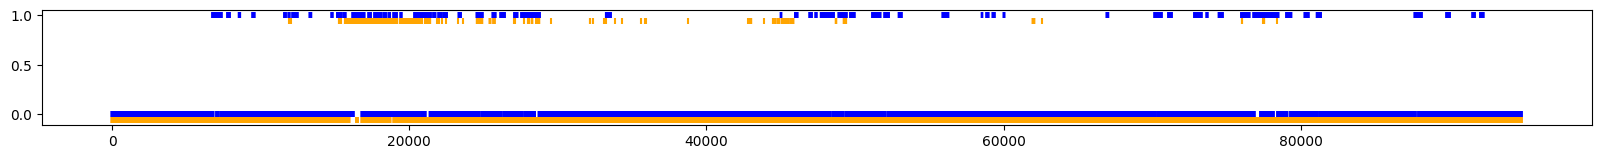

In [27]:
fig, ax = plt.subplots(figsize=(20, 1.5))
ax.scatter(mini_val.index, mini_val['obstruction_ro'], s=25, color='blue', marker="|")
ax.scatter(mini_val.index, mini_val['pred_tf']-.06, s=25, color='orange', marker="|")

plt.show()

Confusion Matrix:
 [[81999  1561]
 [10187  1107]]
F1:
 0.15857327030511387


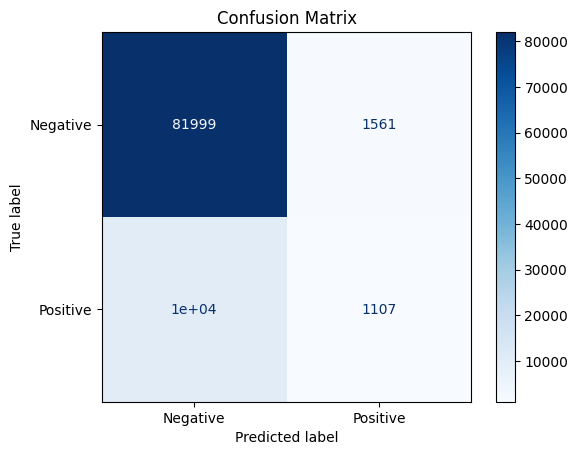

In [28]:
# Compute the confusion matrix
cm = confusion_matrix(mini_val['obstruction_ro'].tolist(), mini_val['pred_tf'].tolist())
print("Confusion Matrix:\n", cm)

# F1
print("F1:\n", f1_score(mini_val['obstruction_ro'].tolist(), mini_val['pred_tf'].tolist()))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

del cm, disp